# Computing features to train a MLP
This notebook will guide you through the use of the `keras` package to train a multilayer perceptron for handwritten digits classification. You are going to computing the histogram of gradients from the images in the `mnist` dataset (LeCun et al. 1998)

## Loading the packages

In [17]:
%pip install tensorflow --upgrade
%pip install keras --upgrade

import numpy as np
from matplotlib import pyplot as pl

from skimage.feature import hog
from skimage import data, color, exposure

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam

from keras.utils import np_utils
from sklearn import metrics as me

%matplotlib inline

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Load the `mnist` dataset and normalize in the range [0, 1]

In [18]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, height, width, 1).astype('float32')
X_test = X_test.reshape(n_test, height, width, 1).astype('float32')

X_train /= 255.0
X_test /= 255.0

n_classes = 10

print(n_train, 'train samples')
print(n_test, 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

60000 train samples
10000 test samples


### An example of how to compute the histogram of gradients
Let's compute the HOG for one image in the test dataset

In [19]:
n_orientations = 16
pix_p_cell = 4
hog_size = int(height * width * n_orientations / (pix_p_cell * pix_p_cell))
hog_size


784

In [20]:
fd, hog_image = hog(X_test[0,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=True)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

Show the image and the corresponding gradients

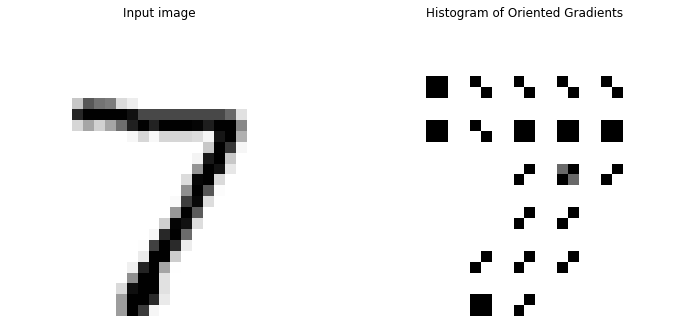

In [21]:
fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(X_test[0,:,:,0], cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax1.set_title('Input image')
ax1.set_adjustable('box')

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box')

Compute the HOGs for the train and test datasets

> Indented block



In [22]:
X_train_hog = np.zeros((X_train.shape[0], hog_size))
X_test_hog = np.zeros((X_test.shape[0], hog_size))

for i in np.arange(X_train_hog.shape[0]):
    X_train_hog[i,:] = hog(X_train[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_train done')

for i in np.arange(X_test_hog.shape[0]):
    X_test_hog[i,:] = hog(X_test[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_test done')

X_train done
X_test done


Create the MLP

In [32]:
model = Sequential()
model.add(Dense(100, input_shape=(hog_size,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 100)               78500     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


Define some constants and train the MLP

In [24]:
batch_size = 256
n_epoch = 10

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
history = model.fit(X_train_hog, Y_train,
                    batch_size=batch_size, epochs=n_epoch,
                    verbose=1, validation_data=(X_test_hog, Y_test))

Epoch 1/10
235/235 [==============================] - 1s 5ms/step - loss: 0.5572 - accuracy: 0.8523 - val_loss: 0.1327 - val_accuracy: 0.9680
Epoch 2/10
235/235 [==============================] - 1s 4ms/step - loss: 0.1782 - accuracy: 0.9494 - val_loss: 0.0930 - val_accuracy: 0.9736
Epoch 3/10
235/235 [==============================] - 1s 4ms/step - loss: 0.1368 - accuracy: 0.9604 - val_loss: 0.0784 - val_accuracy: 0.9761
Epoch 4/10
235/235 [==============================] - 1s 3ms/step - loss: 0.1141 - accuracy: 0.9667 - val_loss: 0.0719 - val_accuracy: 0.9788
Epoch 5/10
235/235 [==============================] - 1s 3ms/step - loss: 0.1019 - accuracy: 0.9683 - val_loss: 0.0683 - val_accuracy: 0.9789
Epoch 6/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0925 - accuracy: 0.9724 - val_loss: 0.0652 - val_accuracy: 0.9796
Epoch 7/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0847 - accuracy: 0.9737 - val_loss: 0.0644 - val_accuracy: 0.9794
Epoch 

Show the performance of the model

Test score: 0.059766918420791626
Test accuracy: 0.9811000227928162


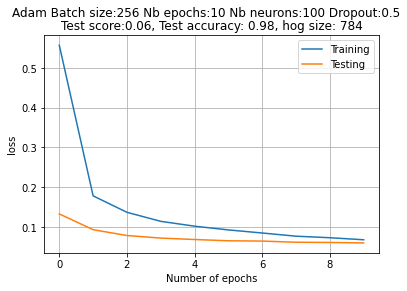

In [31]:
'''pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()
'''
score = model.evaluate(X_test_hog, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

def plot_graph(history, optimName, batch_size, n_epoch, n_neurons, drop, testScore, testAccuracy,hogSize):
    pl.clf()
    pl.plot(history.history['loss'], label='Training')
    pl.plot(history.history['val_loss'], label='Testing')
    pl.ylabel('loss')
    pl.xlabel('Number of epochs')
    pl.suptitle(optimName+' Batch size:'+str(batch_size)+' Nb epochs:'+str(n_epoch)+' Nb neurons:'+str(n_neurons)+' Dropout:'+ ('None' if drop < 0 else str(drop)))
    pl.legend()
    pl.title('Test score:' + str(round(testScore,2)) + ', Test accuracy: '  + str(round(testAccuracy,2))+ ', hog size: '  + str(hogSize))
    pl.grid()
    pl.savefig('../outPutHOG_RMSprop/' + optimName+'_Batch_size'+str(batch_size)+' Nb_epochs'+str(n_epoch)+' Nb_neurons'+str(n_neurons)+'_Dropout_'+ ('None' if drop < 0 else str(drop))  + '.png', dpi=500)
    
plot_graph(history, 'Adam', batch_size, n_epoch,100,0.5,score[0],score[1],784)    

Confusion matrix

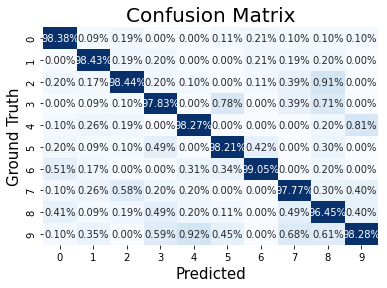

In [29]:
import seaborn as sn
import pandas as pd

pred = model.predict(X_test_hog)
pred = np.argmax(pred, axis=-1)


df_cm = pd.DataFrame(me.confusion_matrix(y_test, pred))
ax = sn.heatmap(df_cm/np.sum(df_cm), annot=True,
            fmt='.2%', cmap='Blues', vmax=0.05, cbar=False)

pl.title('Confusion Matrix', fontsize = 20) # title with fontsize 20
pl.xlabel('Predicted', fontsize = 15) # x-axis label with fontsize 15
pl.ylabel('Ground Truth', fontsize = 15) # y-axis label with fontsize 15

pl.show()

In [30]:
pred = model.predict(X_test_hog)
pred = np.argmax(pred, axis=-1)
me.confusion_matrix(y_test, pred)

array([[ 971,    1,    2,    0,    0,    1,    2,    1,    1,    1],
       [   0, 1125,    2,    2,    0,    0,    2,    2,    2,    0],
       [   2,    2, 1011,    2,    1,    0,    1,    4,    9,    0],
       [   0,    1,    1,  990,    0,    7,    0,    4,    7,    0],
       [   1,    3,    2,    0,  966,    0,    0,    0,    2,    8],
       [   2,    1,    1,    5,    0,  876,    4,    0,    3,    0],
       [   5,    2,    0,    0,    3,    3,  943,    0,    2,    0],
       [   1,    3,    6,    2,    2,    0,    0, 1007,    3,    4],
       [   4,    1,    2,    5,    2,    1,    0,    5,  950,    4],
       [   1,    4,    0,    6,    9,    4,    0,    7,    6,  972]],
      dtype=int64)